In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.stats.api as sms

from bounds import *
from dgp import *
from vset import *
import estimation, utils, experiments


In [2]:
Dx, Du = 5, 0
nD = Dx+Du

dgp = {
    'N': 10000,
    'Dx': Dx,
    'Du': Du,
    'nz': 10,                # Number of finite pre-treatment values
    'beta_zy': 0,            # Z -> Y loading (=0 ==> exclusion restriction is satisfied)
    'e1_coeffs': 4*np.random.rand(nD) - 2,
    'z_coeffs':  4*np.random.rand(nD) - 2,
    'mu1_coeffs': 4*np.random.rand(nD) - 1,
    'mu0_coeffs': 4*np.random.rand(nD) - 2,
    'lambda': 2
}

msm_dgp = set_dgp_config(dgp, 'MSM')
data = generate_data(msm_dgp)


## Test learning outcome probabilities

In [3]:
msm_dgp = set_dgp_config(dgp, 'MSM')
data = generate_data(msm_dgp)
estimation.estimate_bounds(msm_dgp, data, id_method='MSM', est_method='oracle', K=5)

,Rs_down,Rs_up,Rd_down,Rd_up,Rs_coverage,Rd_coverage,R_oracle,metric,id_method,est_method
0,-0.441619,0.208191,-0.299639,0.050532,1,1,-0.027527,m_y=1,MSM,oracle
1,-0.458696,0.179553,-0.323413,0.019484,1,0,-0.330517,m_y=0,MSM,oracle
2,-0.618582,0.518474,-0.236612,0.136504,1,0,0.140296,m_a=0,MSM,oracle
3,-0.116298,0.265752,-0.116298,0.265752,1,1,0.145493,m_a=1,MSM,oracle
4,-0.366898,0.397098,-0.119305,0.149505,1,1,0.108100,m_u,MSM,oracle


In [4]:
estimation.estimate_bounds(msm_dgp, data, id_method='MSM', est_method='plugin', K=5)

outcome regression error: 0.017242383554872683
propensitiy error: 0.012358484350427095
outcome regression error: 0.01411443811288936
propensitiy error: 0.011504366981608158
outcome regression error: 0.015540532624975128
propensitiy error: 0.01209095607837298
outcome regression error: 0.021217029812268428
propensitiy error: 0.017679170554371234
outcome regression error: 0.02127950003527053
propensitiy error: 0.01337817133538801


,Rs_down,Rs_up,Rd_down,Rd_up,Rs_coverage,Rd_coverage,R_oracle,metric,id_method,est_method
0,-0.445189,0.201745,-0.304393,0.043299,1.0,1.0,-0.027527,m_y=1,MSM,plugin
1,-0.462168,0.172943,-0.328081,0.012810,1.0,0.4,-0.330517,m_y=0,MSM,plugin
2,-0.600544,0.513288,-0.226331,0.139075,1.0,0.4,0.140296,m_a=0,MSM,plugin
3,-0.118949,0.255150,-0.118949,0.255150,1.0,1.0,0.145493,m_a=1,MSM,plugin
4,-0.359073,0.389273,-0.116508,0.146708,1.0,1.0,0.108100,m_u,MSM,plugin


In [5]:
iv_dgp = set_dgp_config(dgp, 'IV')
data = generate_data(iv_dgp)

estimation.estimate_bounds(iv_dgp, data, id_method='IV', est_method='oracle', K=5)

,Rs_down,Rs_up,Rd_down,Rd_up,Rs_coverage,Rd_coverage,R_oracle,metric,id_method,est_method
0,-0.321215,-0.249859,-0.306395,-0.264979,0,0,-0.438652,m_y=1,IV,oracle
1,-0.321986,-0.250774,-0.307198,-0.265859,0,0,-0.457114,m_y=0,IV,oracle
2,-0.600285,-0.361741,-0.559139,-0.402888,0,0,0.021972,m_a=0,IV,oracle
3,0.110828,0.151949,0.110828,0.151949,0,0,0.005917,m_a=1,IV,oracle
4,-0.040038,0.042238,-0.013037,0.015237,1,1,0.005200,m_u,IV,oracle


In [6]:
estimation.estimate_bounds(iv_dgp, data, id_method='IV', est_method='plugin', K=5)

outcome regression error: 0.013179168327709654
propensitiy error: 0.007354104119211785
outcome regression error: 0.011344747222133965
propensitiy error: 0.007974706455584585
outcome regression error: 0.009523446656802865
propensitiy error: 0.00786736319175228
outcome regression error: 0.011883723252528847
propensitiy error: 0.009769759106734742
outcome regression error: 0.01733849012828145
propensitiy error: 0.0057219469900604775


,Rs_down,Rs_up,Rd_down,Rd_up,Rs_coverage,Rd_coverage,R_oracle,metric,id_method,est_method
0,-0.476630,-0.380317,-0.458971,-0.398397,1.0,1.0,-0.438652,m_y=1,IV,plugin
1,-0.476953,-0.380940,-0.459341,-0.398968,1.0,0.6,-0.457114,m_y=0,IV,plugin
2,-0.156927,0.074383,-0.117068,0.034525,1.0,0.8,0.021972,m_a=0,IV,plugin
3,-0.003534,0.036441,-0.003534,0.036441,1.0,1.0,0.005917,m_a=1,IV,plugin
4,-0.038798,0.040998,-0.012643,0.014843,1.0,1.0,0.005200,m_u,IV,plugin


# Coverage sample size experiment 
- Construct 95% bootstrap CI around plug-in estimates of the regret. Plot as a function of sample size.
- Also plot coverage as a function of sample size.

In [3]:
Dx, Du = 5, 2
nD = Dx+Du

dgp = {
    'N': 10000,
    'Dx': Dx,
    'Du': Du,
    'nz': 10,                # Number of finite pre-treatment values
    'beta_zy': 0,            # Z -> Y loading (=0 ==> exclusion restriction is satisfied)
    'e1_coeffs': 4*np.random.rand(nD) - 2,
    'z_coeffs':  4*np.random.rand(nD) - 2,
    'mu1_coeffs': 4*np.random.rand(nD) - 1,
    'mu0_coeffs': 4*np.random.rand(nD) - 2,
    'lambda': 1.5
}

msm_dgp = set_dgp_config(dgp, 'MSM')
Ns = [100, 300, 600, 900, 1200, 1500, msm_dgp['N']-1]
coveragedf = experiments.estimation_coverage_experiment(msm_dgp, Ns, Nsims=30)



outcome regression error: 0.171271346667545
propensitiy error: 0.08462333280299203
outcome regression error: 0.12593415169038147
propensitiy error: 0.14350400015549514
outcome regression error: 0.08885989978541639
propensitiy error: 0.08807502793784885
outcome regression error: 0.06686000853020342
propensitiy error: 0.1382298156861867
outcome regression error: 0.1349731633285806
propensitiy error: 0.15715572582333062
outcome regression error: 0.16801960866981117
propensitiy error: 0.09007325747339104
outcome regression error: 0.13669837374457053
propensitiy error: 0.11974058893637826
outcome regression error: 0.21653175210295653
propensitiy error: 0.09044686558126037
outcome regression error: 0.17453956273828047
propensitiy error: 0.1954563825549784
outcome regression error: 0.16780237967049944
propensitiy error: 0.1246305951098425
outcome regression error: 0.17298762839220075
propensitiy error: 0.08060638438484649
outcome regression error: 0.10357744904859752
propensitiy error: 0.0777

outcome regression error: 0.08006508508197871
propensitiy error: 0.161398468207501
outcome regression error: 0.15146676538765322
propensitiy error: 0.16249905057044103
outcome regression error: 0.1766373344677373
propensitiy error: 0.09140064256576687
outcome regression error: 0.0938660568585254
propensitiy error: 0.08060406143987056
outcome regression error: 0.11789851086841781
propensitiy error: 0.10094244914414248
outcome regression error: 0.06746437388565903
propensitiy error: 0.08881993912323723
outcome regression error: 0.09712060480522992
propensitiy error: 0.15799903444115365
outcome regression error: 0.13311992171752304
propensitiy error: 0.18500346325314354
outcome regression error: 0.2298761058021319
propensitiy error: 0.18163553755321266
outcome regression error: 0.16837467678769674
propensitiy error: 0.1676241077533792
outcome regression error: 0.2118324537817334
propensitiy error: 0.17369103177916384
outcome regression error: 0.1873095041231632
propensitiy error: 0.137995

outcome regression error: 0.10795302074084928
propensitiy error: 0.07826407336368925
outcome regression error: 0.07959339339984213
propensitiy error: 0.08008389260488553
outcome regression error: 0.12353627252793115
propensitiy error: 0.09103691025886146
outcome regression error: 0.0963045510287976
propensitiy error: 0.06633582365884608
outcome regression error: 0.0728334043321665
propensitiy error: 0.08600316783721157
outcome regression error: 0.07347633414798402
propensitiy error: 0.07310178174468032
outcome regression error: 0.10057313472522894
propensitiy error: 0.05726403474554272
outcome regression error: 0.12169292643070954
propensitiy error: 0.06985029184833492
outcome regression error: 0.13363186136400146
propensitiy error: 0.06692169275385354
outcome regression error: 0.10216012924800112
propensitiy error: 0.06093140532671511
outcome regression error: 0.13925161764645091
propensitiy error: 0.05300494859645563
outcome regression error: 0.0652507558705396
propensitiy error: 0.0

outcome regression error: 0.08125549543415976
propensitiy error: 0.06437807300058279
outcome regression error: 0.07419672809993502
propensitiy error: 0.0594327927575822
outcome regression error: 0.05008248722935282
propensitiy error: 0.060433434342026485
outcome regression error: 0.053497665826093624
propensitiy error: 0.06622052422940031
outcome regression error: 0.05501289414731092
propensitiy error: 0.054400768752798444
outcome regression error: 0.05175904148903453
propensitiy error: 0.06445098473813402
outcome regression error: 0.051803644199254206
propensitiy error: 0.08077387941285089
outcome regression error: 0.060785787663436786
propensitiy error: 0.056999231346524806
outcome regression error: 0.06737903975312083
propensitiy error: 0.057038307036258444
outcome regression error: 0.07808729609051476
propensitiy error: 0.05807122912329368
outcome regression error: 0.0777733038963923
propensitiy error: 0.06540466936280195
outcome regression error: 0.06526083651064055
propensitiy er

outcome regression error: 0.07409148456098838
propensitiy error: 0.0743528771063985
outcome regression error: 0.07503013213178246
propensitiy error: 0.05270289806606512
outcome regression error: 0.07803848622367066
propensitiy error: 0.07699147467819942
outcome regression error: 0.07064490866413527
propensitiy error: 0.06462347293654089
outcome regression error: 0.04111668559548553
propensitiy error: 0.059126188878399856
outcome regression error: 0.03892588539414202
propensitiy error: 0.05593115140293037
outcome regression error: 0.05966462559442347
propensitiy error: 0.04789211851208611
outcome regression error: 0.052199559600321896
propensitiy error: 0.06466087467550945
outcome regression error: 0.046577691813859894
propensitiy error: 0.0909703081331291
outcome regression error: 0.048878136604686324
propensitiy error: 0.07379751543614842
outcome regression error: 0.05381379614331642
propensitiy error: 0.07217417921269938
outcome regression error: 0.07065931214946881
propensitiy error

outcome regression error: 0.04992527629093946
propensitiy error: 0.06065625396564149
outcome regression error: 0.05297143459330817
propensitiy error: 0.052524869637052114
outcome regression error: 0.049748711118927806
propensitiy error: 0.057111434962023484
outcome regression error: 0.060623795740540984
propensitiy error: 0.054674565862300586
outcome regression error: 0.04224563439490471
propensitiy error: 0.055604855039198535
outcome regression error: 0.05956614006523254
propensitiy error: 0.047575673928847304
outcome regression error: 0.05341712602719589
propensitiy error: 0.05727923002744591
outcome regression error: 0.08083817528990023
propensitiy error: 0.04427704655722611
outcome regression error: 0.06112339384419821
propensitiy error: 0.05149812992148232
outcome regression error: 0.06787629558734157
propensitiy error: 0.05298443179707879
outcome regression error: 0.05244672701289286
propensitiy error: 0.051316363634336316
outcome regression error: 0.049354545064973304
propensiti

outcome regression error: 0.04964148572557816
propensitiy error: 0.059973134775035165
outcome regression error: 0.04706339269939907
propensitiy error: 0.048294093209376575
outcome regression error: 0.06494446049644909
propensitiy error: 0.05091149355616134
outcome regression error: 0.04472359747693718
propensitiy error: 0.06371126342657617
outcome regression error: 0.055719966045092065
propensitiy error: 0.06446216426058939
outcome regression error: 0.0658799611157447
propensitiy error: 0.07011142735694993
outcome regression error: 0.03935625094365987
propensitiy error: 0.058381632295854066
outcome regression error: 0.03756013903302497
propensitiy error: 0.06696488553933454
outcome regression error: 0.04499727898258129
propensitiy error: 0.051725983981984656
outcome regression error: 0.05217962937486677
propensitiy error: 0.05500618628560004
outcome regression error: 0.05066562695284818
propensitiy error: 0.04658210052773152
outcome regression error: 0.03964419324607827
propensitiy err

outcome regression error: 0.03596294430064761
propensitiy error: 0.055129349747258125
outcome regression error: 0.052287102914265415
propensitiy error: 0.07141653025944325
outcome regression error: 0.04986484758400066
propensitiy error: 0.05594923717511208
outcome regression error: 0.06583215832995717
propensitiy error: 0.054431257960546514
outcome regression error: 0.06007830304225128
propensitiy error: 0.06308527609635319
outcome regression error: 0.06162622252186374
propensitiy error: 0.06406967685415302
outcome regression error: 0.06286146495386055
propensitiy error: 0.05909571449295307
outcome regression error: 0.0478018788492218
propensitiy error: 0.0473785913946204
outcome regression error: 0.04997206006594261
propensitiy error: 0.054010629458034067
outcome regression error: 0.04390846480991048
propensitiy error: 0.05601382504567134
outcome regression error: 0.03777707381124121
propensitiy error: 0.052397725456918405
outcome regression error: 0.05924961653468477
propensitiy erro

outcome regression error: 0.058157844023440826
propensitiy error: 0.04740188438020986
outcome regression error: 0.0621602430564365
propensitiy error: 0.05130570416306581
outcome regression error: 0.05553488502436417
propensitiy error: 0.05622209690051567
outcome regression error: 0.054002258198682325
propensitiy error: 0.046299329766745626
outcome regression error: 0.03854497768000349
propensitiy error: 0.04820655118355545
outcome regression error: 0.04137613901572838
propensitiy error: 0.0663930574144284
outcome regression error: 0.04408711657744201
propensitiy error: 0.0504267059858534
outcome regression error: 0.03885230238526753
propensitiy error: 0.05468875342350825
outcome regression error: 0.03449655810551155
propensitiy error: 0.05379927826660775
outcome regression error: 0.04802618016724676
propensitiy error: 0.05678179379848863
outcome regression error: 0.041323104295364406
propensitiy error: 0.06230553186934376
outcome regression error: 0.05671283929678063
propensitiy error:

outcome regression error: 0.03385765442819846
propensitiy error: 0.04556113815392132
outcome regression error: 0.028677105767813096
propensitiy error: 0.04420884088296266
outcome regression error: 0.03146866286808396
propensitiy error: 0.04230100250958504
outcome regression error: 0.027825608259661322
propensitiy error: 0.04383877321344521
outcome regression error: 0.027882676518047808
propensitiy error: 0.043866481390937975
outcome regression error: 0.029740259650605293
propensitiy error: 0.04344526657013979
outcome regression error: 0.03278431227254285
propensitiy error: 0.04392562572984956
outcome regression error: 0.029308983971924663
propensitiy error: 0.04394077387641614
outcome regression error: 0.028917744030367305
propensitiy error: 0.0436816970867936
outcome regression error: 0.02930000948812151
propensitiy error: 0.044997638467210395
outcome regression error: 0.030470061462291226
propensitiy error: 0.04532480136862955
outcome regression error: 0.030825771115461698
propensiti

outcome regression error: 0.03151543863724539
propensitiy error: 0.04502164940106366
outcome regression error: 0.030801642687082218
propensitiy error: 0.04456767923697295
outcome regression error: 0.02923938375799452
propensitiy error: 0.04326928419974062
outcome regression error: 0.030270147414255582
propensitiy error: 0.04337936950982993
outcome regression error: 0.028601377324582334
propensitiy error: 0.04350684612935046


Text(0, 0.5, 'Accuracy regret')

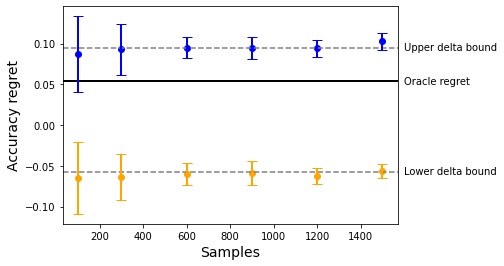

In [17]:
ns_data = experiments.get_est_exp_metadata(coveragedf, Ns)
ns_data = ns_data[ns_data['metric'] == 'm_u']

oracle_up = ns_data['Rd_up_oracle'].tolist()[-1]
oracle_down = ns_data['Rd_down_oracle'].tolist()[-1]
oracle = ns_data['R_oracle'].tolist()[-1]
ns_data = ns_data.iloc[:-1,:]

plt.axhline(oracle_up, color='grey', linestyle='--')
plt.axhline(oracle_down, color='grey', linestyle='--')
plt.axhline(oracle, color='k', linewidth=2,label='$R^*$')

plt.scatter(ns_data['N'], ns_data['Rd_up_pl_mean'], color='blue')
for ix,n in enumerate(ns_data['N']):
    plt.errorbar(n, ns_data['Rd_up_pl_mean'].tolist()[ix], yerr=ns_data['Rd_up_pl_ci'].tolist()[ix],capsize=5, linewidth=2, elinewidth=2, color='blue')

plt.scatter(ns_data['N'], ns_data['Rd_down_pl_mean'], color='orange')
for ix,n in enumerate(ns_data['N']):
    plt.errorbar(n, ns_data['Rd_down_pl_mean'].tolist()[ix], yerr=ns_data['Rd_down_pl_ci'].tolist()[ix],capsize=5, linewidth=2, elinewidth=2, color='orange')
    
# Determine the X location for the text boxes (adjust as needed)
x_loc = max(ns_data['N']) + 100  # Adjust the offset (10 here) as needed

# Add text boxes
plt.text(x_loc, oracle_up, 'Upper delta bound', va='center')
plt.text(x_loc, oracle_down, r'Lower delta bound', va='center', clip_on=False)
plt.text(x_loc, oracle, 'Oracle regret', va='center')

plt.xlabel('Samples', fontsize=14)
plt.ylabel('Accuracy regret', fontsize=14)

Text(0, 0.5, 'Coverage (%)')

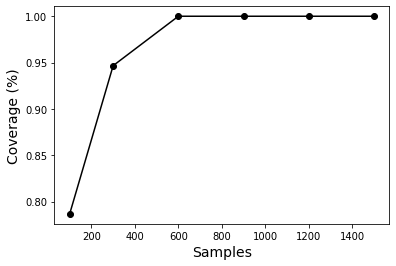

In [18]:
samples = coveragedf[(coveragedf['est_method'] == 'plugin') & (coveragedf['metric'] == 'm_u')]
coverage = samples.groupby('N').mean()['Rd_coverage'].tolist()[:-1]
N = samples.groupby('N').mean().reset_index()['N'].tolist()[:-1]

plt.plot(N, coverage, marker='o', color='k')
plt.xlabel('Samples', fontsize=14)
plt.ylabel('Coverage (%)', fontsize=14)

Text(0, 0.5, 'Coverage (%)')

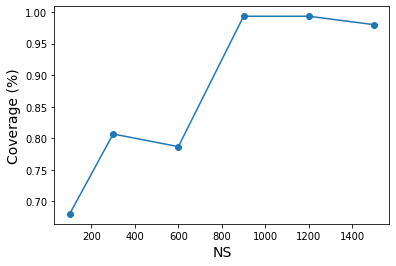